In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

In [2]:
df = pd.read_csv('daily_sales_french_bakery.csv', parse_dates = ['ds'])
df = df.groupby('unique_id').filter(lambda x: len(x) >=28) # Keep only elements with over 28 time steps (need sufficient data for forecasting)
df = df.drop(["unit_price"], axis = 1) #not needed

In [3]:
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


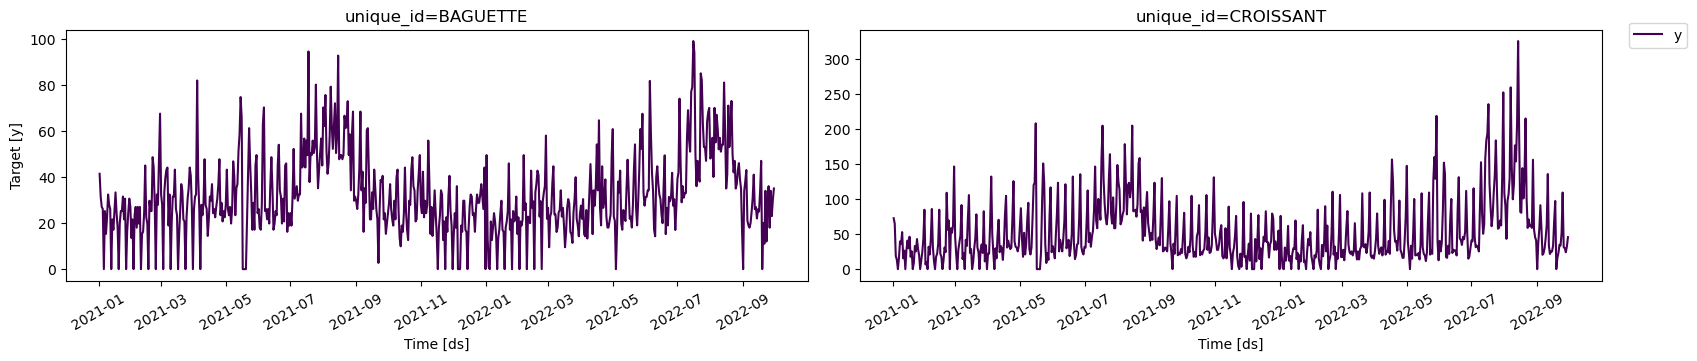

In [4]:
plot_series(df = df, ids = ["BAGUETTE", "CROISSANT"], palette = 'viridis')

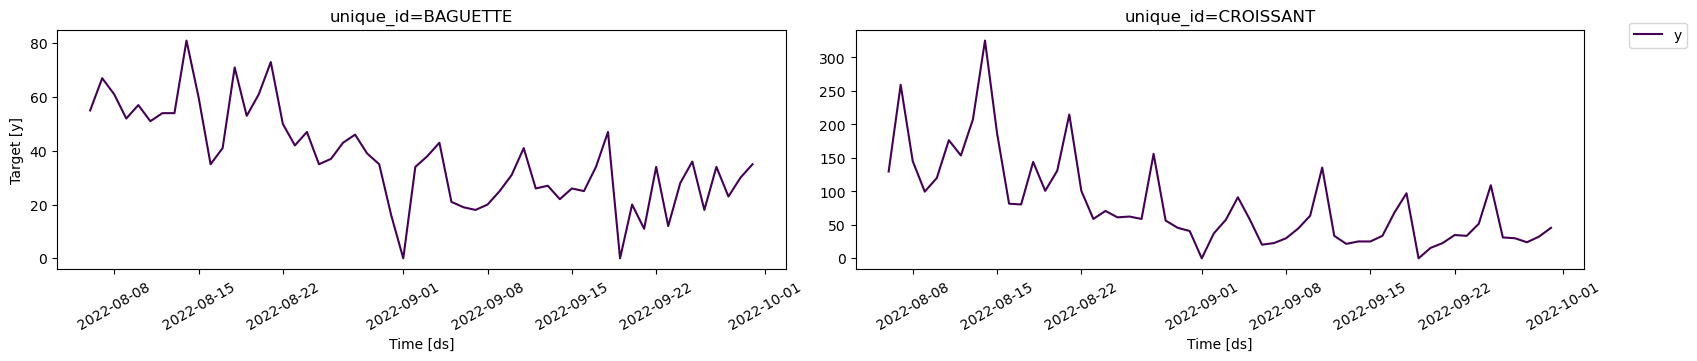

In [5]:
plot_series(df = df, ids = ["BAGUETTE", "CROISSANT"], max_insample_length = 56, palette = 'viridis')

# Baseline Models

In [7]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [8]:
horizon = 7
models=[
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size = 7),
    SeasonalNaive(season_length = 7) #Look at graph (or periodigram?)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [9]:
preds.head(10)

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0
5,12 MACARON,2022-10-04,10.0,8.974359,2.857143,0.0
6,12 MACARON,2022-10-05,10.0,8.974359,2.857143,10.0
7,BAGUETTE,2022-10-01,35.0,32.152904,29.142857,28.0
8,BAGUETTE,2022-10-02,35.0,32.152904,29.142857,36.0
9,BAGUETTE,2022-10-03,35.0,32.152904,29.142857,18.0


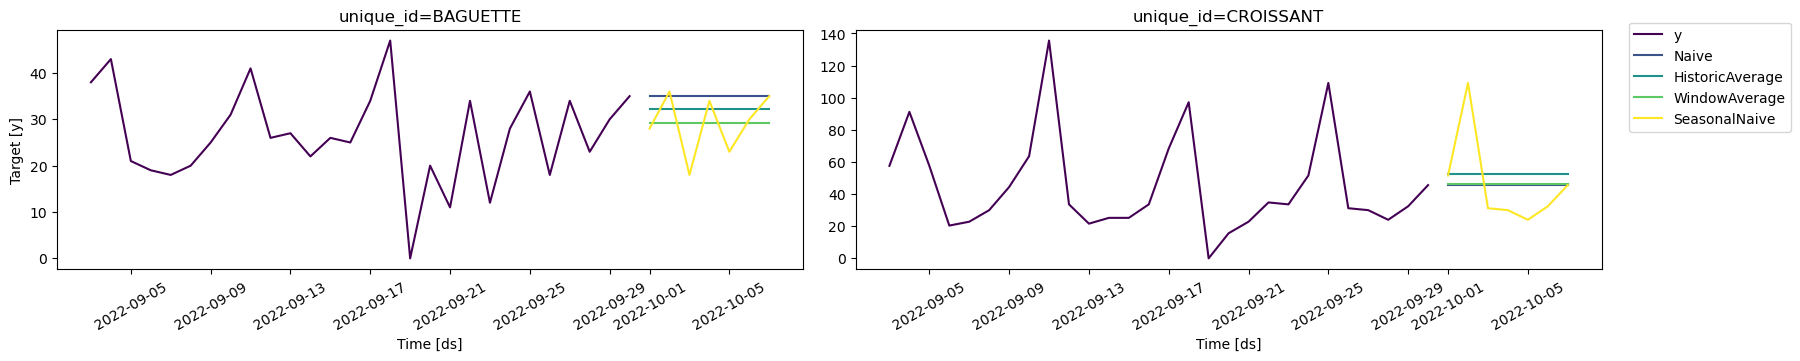

In [10]:
plot_series(df = df,
            forecasts_df=preds,
            ids = ["BAGUETTE", "CROISSANT"],
            max_insample_length = 28,
            palette = 'viridis'
           )

Evaluate baseline models

In [12]:
test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [13]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [14]:
eval_df

,unique_id,ds,y,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-22,0.0,0.0,9.577465,1.428571,10.0
1,12 MACARON,2022-09-23,0.0,0.0,9.577465,1.428571,0.0
2,12 MACARON,2022-09-24,10.0,0.0,9.577465,1.428571,0.0
3,12 MACARON,2022-09-25,0.0,0.0,9.577465,1.428571,0.0
4,12 MACARON,2022-09-26,0.0,0.0,9.577465,1.428571,0.0
...,...,...,...,...,...,...,...
842,VIK BREAD,2022-09-26,0.0,24.3,14.590794,11.957143,0.0
843,VIK BREAD,2022-09-27,0.0,24.3,14.590794,11.957143,0.0
844,VIK BREAD,2022-09-28,0.0,24.3,14.590794,11.957143,0.0
845,VIK BREAD,2022-09-29,0.0,24.3,14.590794,11.957143,0.0


In [15]:
evaluation = evaluate(
    eval_df,
    metrics=[mae]
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [16]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

In [17]:
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


# AutoARIMA

In [19]:
from statsforecast.models import AutoARIMA

In [20]:
unique_ids = ["BAGUETTE", "CROISSANT"]

In [21]:
small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

In [22]:
arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics = [mae]
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449084,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [23]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean()

In [24]:
arima_eval

,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
metric,,,,,,
mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


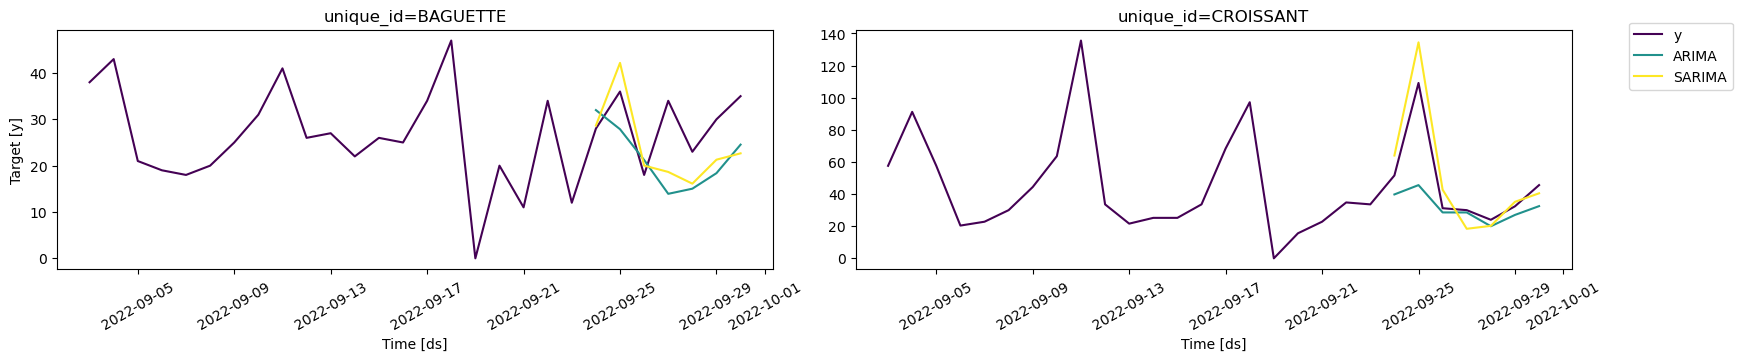

In [25]:
plot_series(df = df,
            forecasts_df=arima_preds,
            ids = ["BAGUETTE", "CROISSANT"],
            max_insample_length = 28,
            palette = 'viridis'
           )

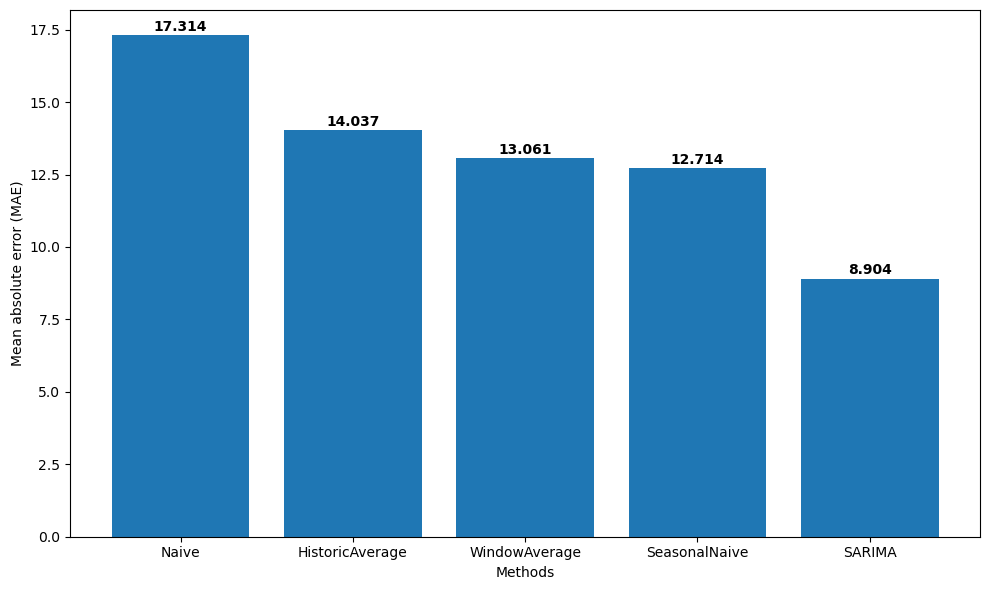

In [26]:
methods = arima_eval.columns[1:].tolist()  
values = arima_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

# Cross Validation

In [28]:
small_df = df[df["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length = 7),
    AutoARIMA(seasonal=False, alias='ARIMA'),
    AutoARIMA(season_length=7, alias='SARIMA')
]

sf = StatsForecast(models=models, freq='D')

In [29]:
cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon, #avoid overlapping, if step_size<horizon ==> overlapping data
    refit=True #Do you want to refit the model everytime the input changes
)



In [30]:
cv_df.head(20)

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355198,71.584715
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337981,78.458885
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195006,57.001733
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649015,49.401146
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785877,49.725280
5,BAGUETTE,2022-08-11,2022-08-05,51.0,40.0,53.274424,48.316342
6,BAGUETTE,2022-08-12,2022-08-05,54.0,70.0,63.513710,56.860491
7,BAGUETTE,2022-08-13,2022-08-12,54.0,55.0,64.160215,62.947273
8,BAGUETTE,2022-08-14,2022-08-12,81.0,67.0,63.299748,73.838571
9,BAGUETTE,2022-08-15,2022-08-12,60.0,61.0,58.018991,56.233368


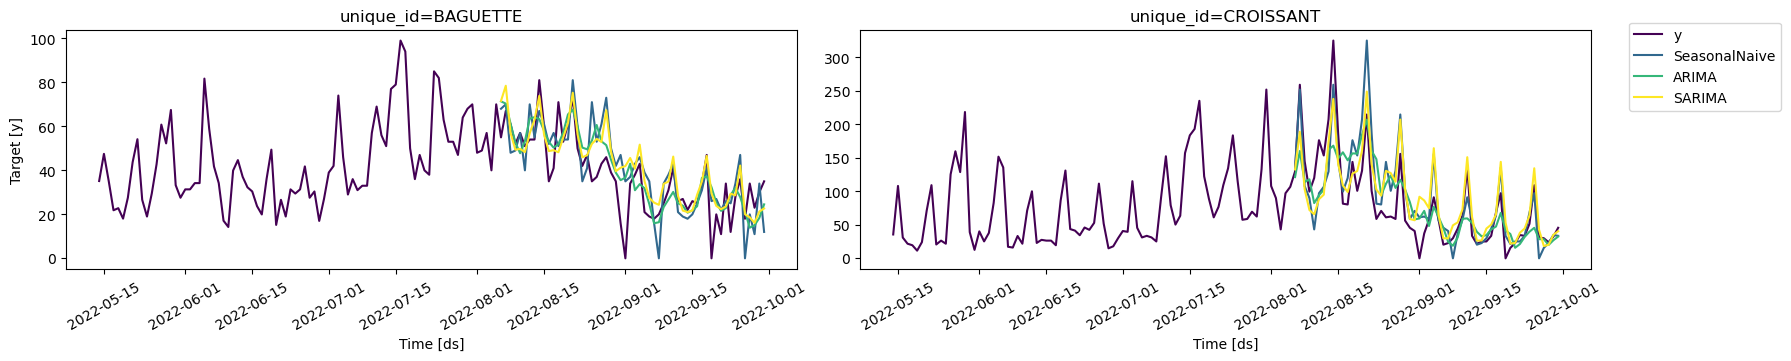

In [31]:
plot_series(df = df,
            forecasts_df=cv_df.drop(columns=['y','cutoff']),
            ids = ["BAGUETTE", "CROISSANT"],
            max_insample_length = 140,
            palette = 'viridis'
           )

In [32]:
cv_eval = evaluate(
    cv_df.drop(columns=['cutoff']),
    metrics=[mae]
)

cv_eval = cv_eval.drop(columns=['unique_id']).groupby('metric').mean().reset_index()

In [33]:
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.170931,19.281295


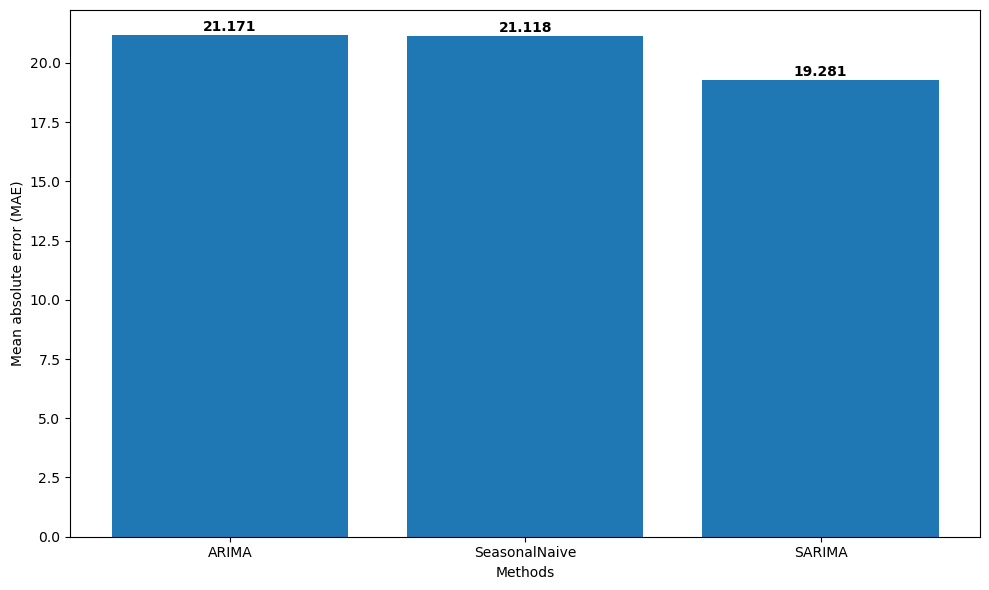

In [34]:
methods = cv_eval.columns[1:].tolist()  
values = cv_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

# Exogenous features

In [36]:
df = pd.read_csv('daily_sales_french_bakery.csv', parse_dates = ['ds'])
df = df.groupby('unique_id').filter(lambda x: len(x) >=28) #price now considered as a feature

In [37]:
df

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0
...,...,...,...,...
57041,VIK BREAD,2022-09-26,0.0,2.7
57042,VIK BREAD,2022-09-27,0.0,2.7
57043,VIK BREAD,2022-09-28,0.0,2.7
57044,VIK BREAD,2022-09-29,0.0,2.7


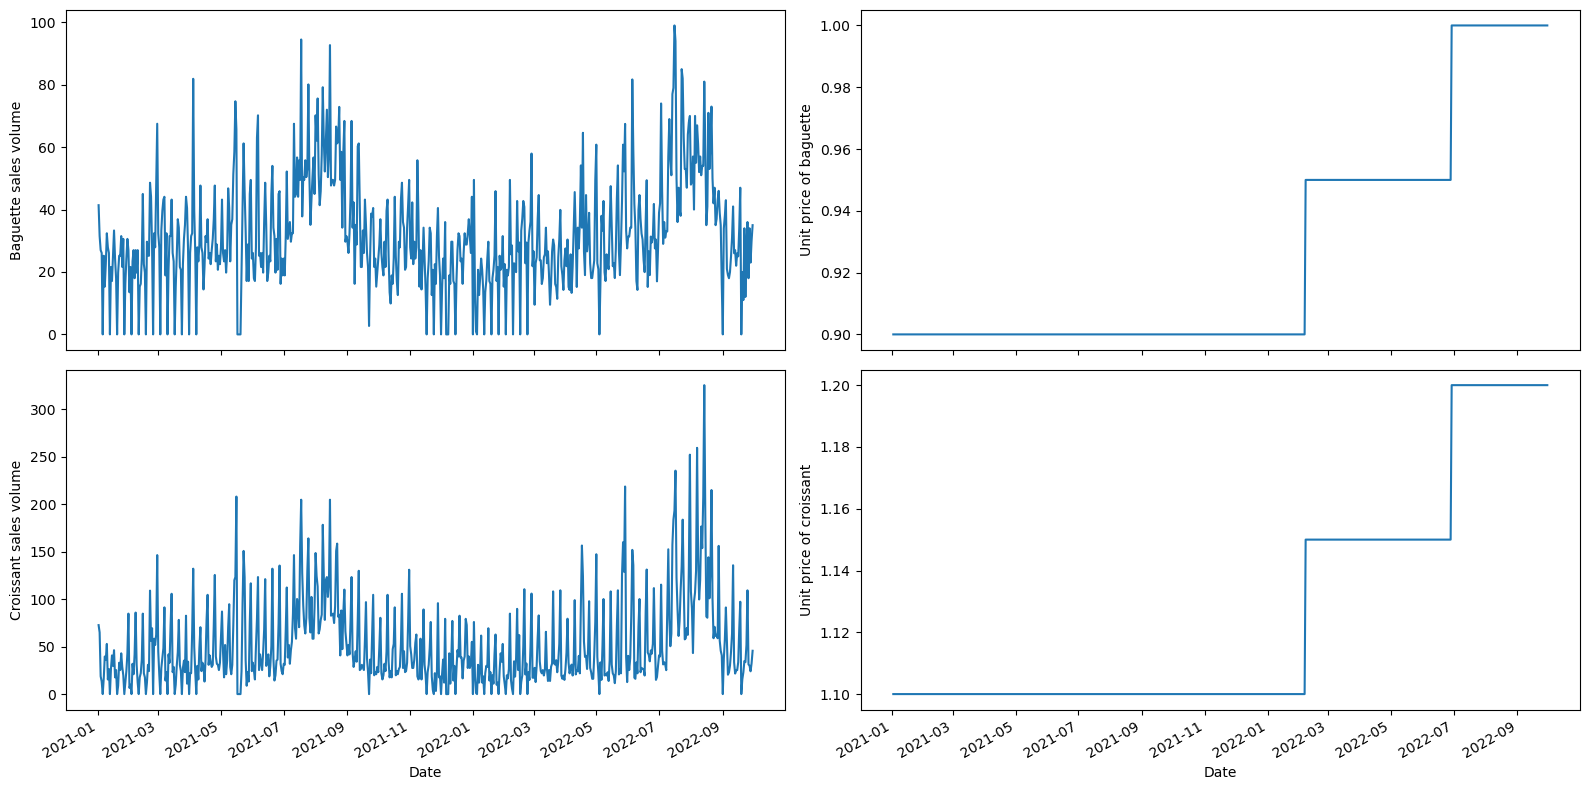

In [38]:
baguette_plot_df = df[df["unique_id"] == "BAGUETTE"]
croissant_plot_df = df[df["unique_id"] == "CROISSANT"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

ax1.plot(baguette_plot_df["ds"], baguette_plot_df["y"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Baguette sales volume")

ax2.plot(baguette_plot_df["ds"], baguette_plot_df["unit_price"])
ax2.set_xlabel("Date")
ax2.set_ylabel("Unit price of baguette")

ax3.plot(croissant_plot_df["ds"], croissant_plot_df["y"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Croissant sales volume")

ax4.plot(croissant_plot_df["ds"], croissant_plot_df["unit_price"])
ax4.set_xlabel("Date")
ax4.set_ylabel("Unit price of croissant")

fig.autofmt_xdate()
plt.tight_layout()

In [39]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [40]:
test

,unique_id,ds,y,unit_price
714,BAGUETTE,2022-09-24,28.0,1.0
715,BAGUETTE,2022-09-25,36.0,1.0
716,BAGUETTE,2022-09-26,18.0,1.0
717,BAGUETTE,2022-09-27,34.0,1.0
718,BAGUETTE,2022-09-28,23.0,1.0
719,BAGUETTE,2022-09-29,30.0,1.0
720,BAGUETTE,2022-09-30,35.0,1.0
13496,CROISSANT,2022-09-24,51.6,1.2
13497,CROISSANT,2022-09-25,109.2,1.2
13498,CROISSANT,2022-09-26,31.2,1.2


In [41]:
futr_exog_df = test.drop(columns=['y'])
futr_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [42]:
models = [
    AutoARIMA(season_length=7, alias='SARIMA_exog')
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)

StatsForecast(models=[SARIMA_exog])

In [43]:
arima_exog_preds = sf.predict(h=horizon, X_df=futr_exog_df)

In [44]:
models = [
    AutoARIMA(season_length=7, alias='SARIMA')
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train.drop(columns = ["unit_price"]))

StatsForecast(models=[SARIMA])

In [45]:
arima_preds = sf.predict(h=horizon)

In [46]:
test_df = test.merge(arima_exog_preds, on=["unique_id","ds"], how="left").merge(arima_preds,  on=["unique_id","ds"], how="left")
test_df

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898805,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.513133,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423812,20.013655
3,BAGUETTE,2022-09-27,34.0,1.0,19.066095,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468747,16.114926
5,BAGUETTE,2022-09-29,30.0,1.0,21.656586,21.288016
6,BAGUETTE,2022-09-30,35.0,1.0,23.101064,22.660125
7,CROISSANT,2022-09-24,51.6,1.2,64.424299,64.011003
8,CROISSANT,2022-09-25,109.2,1.2,135.123242,134.488203
9,CROISSANT,2022-09-26,31.2,1.2,43.524909,42.735408


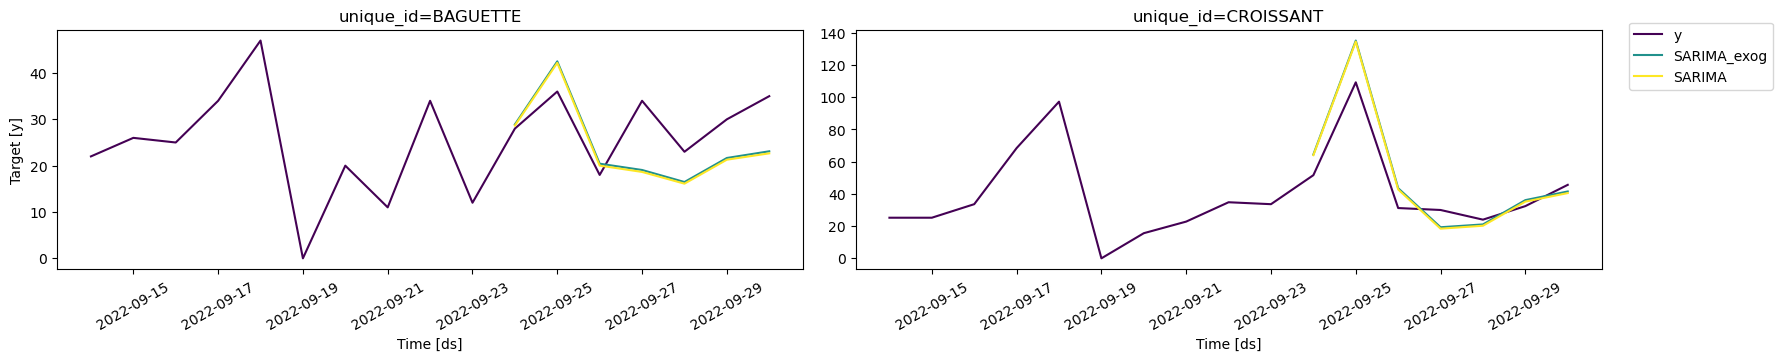

In [47]:
plot_series(df = train,
            forecasts_df=test_df.drop(columns=['unit_price']),
            ids = ["BAGUETTE", "CROISSANT"],
            max_insample_length = 10,
            palette = 'viridis'
           )

In [48]:
models = [
    AutoARIMA(season_length=7, alias='SARIMA_exog')
]
sf = StatsForecast(models=models, freq="D")

#Cross validation


In [49]:
cv_exog_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon, #avoid overlapping, if step_size<horizon ==> overlapping data
    refit=True #Do you want to refit the model everytime the input changes
)

cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511253
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.457742
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062387
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525489
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485269


In [50]:
cv_exog_eval = evaluate(
    cv_exog_df.drop(columns=['cutoff']),
    metrics=[mae]
)

cv_exog_eval = cv_exog_eval.drop(columns=['unique_id']).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,19.210235


# Creating features from timestamps

In [52]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline 
#Fourier terms to encode seasonality, time_features: day of week, month etc, pipeline: create many features in one go
#Partial: Resuse function definitions

In [53]:
features = [
    partial(fourier, season_length=7, k=2), #How many sines and cosines you want to use (2 or 3 more than enough usually)
    partial(time_features, features=["day", "week", "month"])
]

In [54]:
small_exog_df, future_exog_df = pipeline(
    df = small_df,
    features=features,
    freq="D",
    h=horizon
)

In [55]:
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [56]:
future_exog_df

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10
5,BAGUETTE,2022-10-06,-0.781828,-0.974931,0.623495,-0.222509,6,40,10
6,BAGUETTE,2022-10-07,-0.000009,-0.000017,1.000000,1.000000,7,40,10
7,CROISSANT,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
8,CROISSANT,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
9,CROISSANT,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10


In [57]:
models = [
    AutoARIMA(season_length=7, alias='SARIMA_time_exog')
]

sf = StatsForecast(models=models, freq="D")
cv_time_exog_df = sf.cross_validation(
    h=horizon,
    df=small_exog_df,
    n_windows=8,
    step_size=horizon, #avoid overlapping, if step_size<horizon ==> overlapping data
    refit=True #Do you want to refit the model everytime the input changes
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(columns=['cutoff']),
    metrics=[mae]
)

cv_time_exog_eval = cv_time_exog_eval.drop(columns=['unique_id']).groupby('metric').mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_time_exog
0,mae,19.701185


# Prediction Intervals

In [114]:
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq='D')
sf.fit(df=train)
prob_preds = sf.predict(h=horizon, X_df=test.drop(columns = ["y"]), level=[80,90,95])

In [118]:
test_df = test.merge(prob_preds, on=["unique_id", "ds"], how="left")

In [124]:
test_df

,unique_id,ds,y,unit_price,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90,AutoARIMA-hi-95
0,BAGUETTE,2022-09-24,28.0,1.0,28.898805,8.622697,11.882559,15.640971,42.156639,45.915050,49.174912
1,BAGUETTE,2022-09-25,36.0,1.0,42.513133,20.818490,24.306414,28.327768,56.698497,60.719851,64.207776
2,BAGUETTE,2022-09-26,18.0,1.0,20.423812,-1.801348,1.771870,5.891561,34.956062,39.075753,42.648971
3,BAGUETTE,2022-09-27,34.0,1.0,19.066095,-3.530987,0.102026,4.290657,33.841533,38.030165,41.663178
4,BAGUETTE,2022-09-28,23.0,1.0,16.468747,-6.448488,-2.764003,1.483972,31.453522,35.701497,39.385982
5,BAGUETTE,2022-09-29,30.0,1.0,21.656586,-1.551211,2.179989,6.481824,36.831349,41.133184,44.864383
6,BAGUETTE,2022-09-30,35.0,1.0,23.101064,-0.373962,3.400201,7.751569,38.450558,42.801926,46.576090
7,CROISSANT,2022-09-24,51.6,1.2,64.424299,22.219639,29.005032,36.828155,92.020442,99.843566,106.628958
8,CROISSANT,2022-09-25,109.2,1.2,135.123242,87.124691,94.841588,103.738676,166.507808,175.404897,183.121794
9,CROISSANT,2022-09-26,31.2,1.2,43.524909,-7.022162,1.104470,10.473956,76.575863,85.945349,94.071981


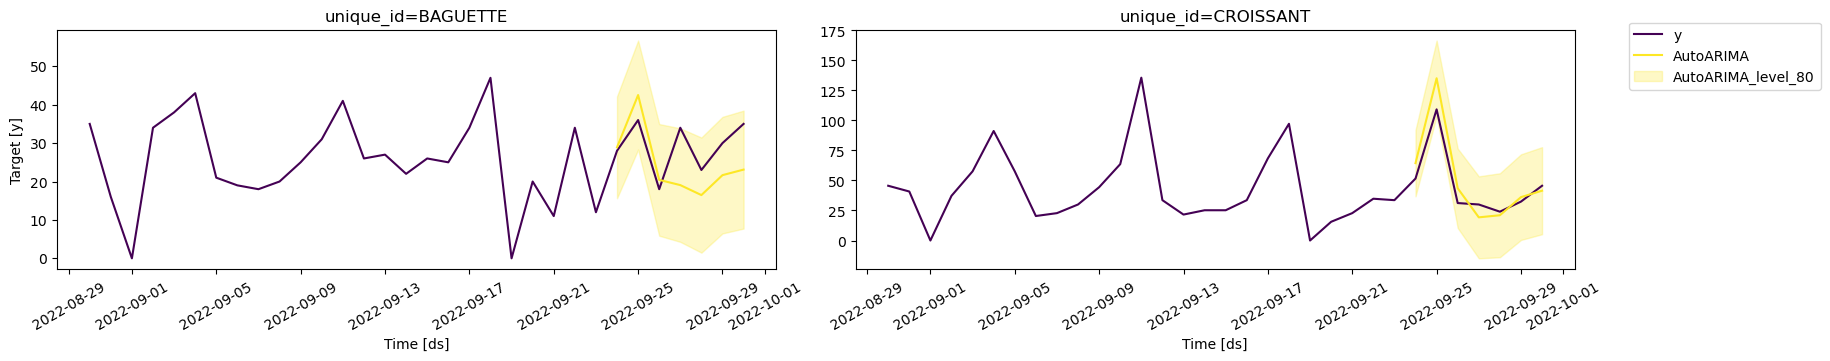

In [147]:
plot_series(df = train,
            forecasts_df=test_df,
            ids = ["BAGUETTE", "CROISSANT"],
            max_insample_length = 25,
            models = ["AutoARIMA"],
            level=[80],
            palette = 'viridis'
           )

In [143]:
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq='D')

cv_prob_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
    level=[80]
)

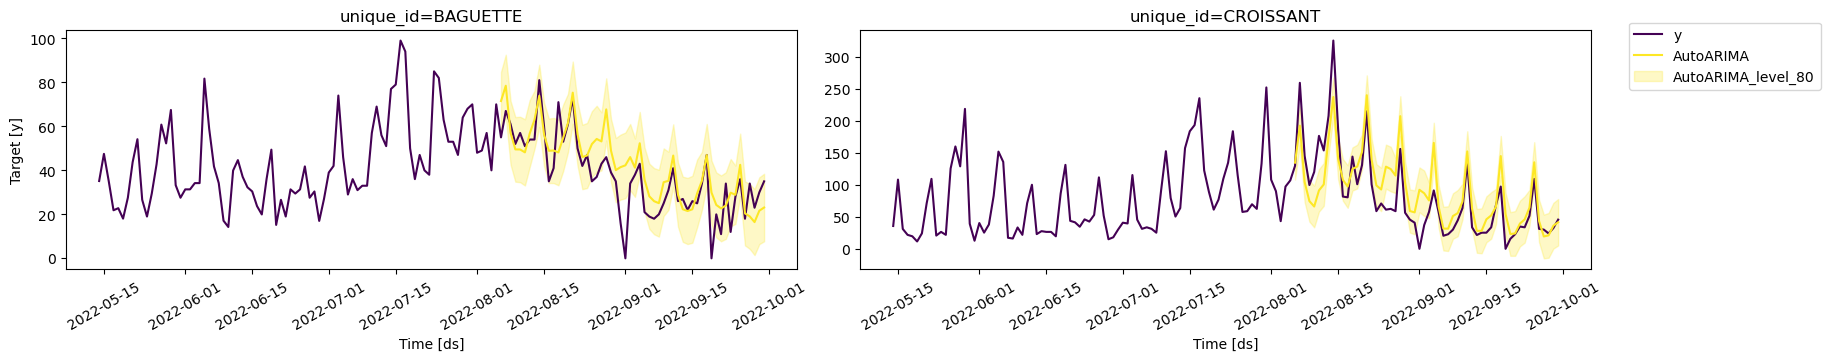

In [155]:
plot_series(df = small_df,
            forecasts_df=cv_prob_df.drop(columns=['y','cutoff']),
            ids = ["BAGUETTE", "CROISSANT"],
            max_insample_length = 140,
            models = ["AutoARIMA"],
            level=[80],
            palette = 'viridis'
           )

# Evaluation metrics

CRPS is generally used for prediction intervals

In [159]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog_price"),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq='D')
final_cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
    level=[80]
)

In [161]:
final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog_price,SARIMA_exog_price-lo-80,SARIMA_exog_price-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511253,58.278934,84.743573,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.457742,64.353800,92.561684,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062387,42.621832,71.502942,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525489,34.846926,64.204052,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485269,34.606417,64.364121,57.0,39.158042,74.841958


In [160]:
temp_test = small_df.groupby("unique_id").tail(7*8)
temp_train = small_df.drop(test.index).reset_index(drop=True)

In [167]:
models = ["SARIMA_exog_price", "SeasonalNaive"]
metrics = [
    mae,
    mse,
    rmse,
    mape,  #Mean absolute percentage error
    smape,  #Symmetric Mean absolute percentage error
    partial(mase, seasonality=7), #Mean absolute scaled error
    scaled_crps
]

final_eval = evaluate(
    final_cv_df.drop(columns = ['ds', 'cutoff']),
    metrics = metrics,
    models = models,
    train_df = temp_train,
    level = [80]
)

final_eval = final_eval.drop(columns = ['unique_id']).groupby('metric').mean().reset_index()

In [169]:
final_eval

,metric,SARIMA_exog_price,SeasonalNaive
0,mae,19.210235,21.117857
1,mape,0.328596,0.376819
2,mase,1.140718,1.285069
3,mse,792.641646,970.417143
4,rmse,24.977638,27.875413
5,scaled_crps,0.153621,0.166451
6,smape,0.168232,0.211317


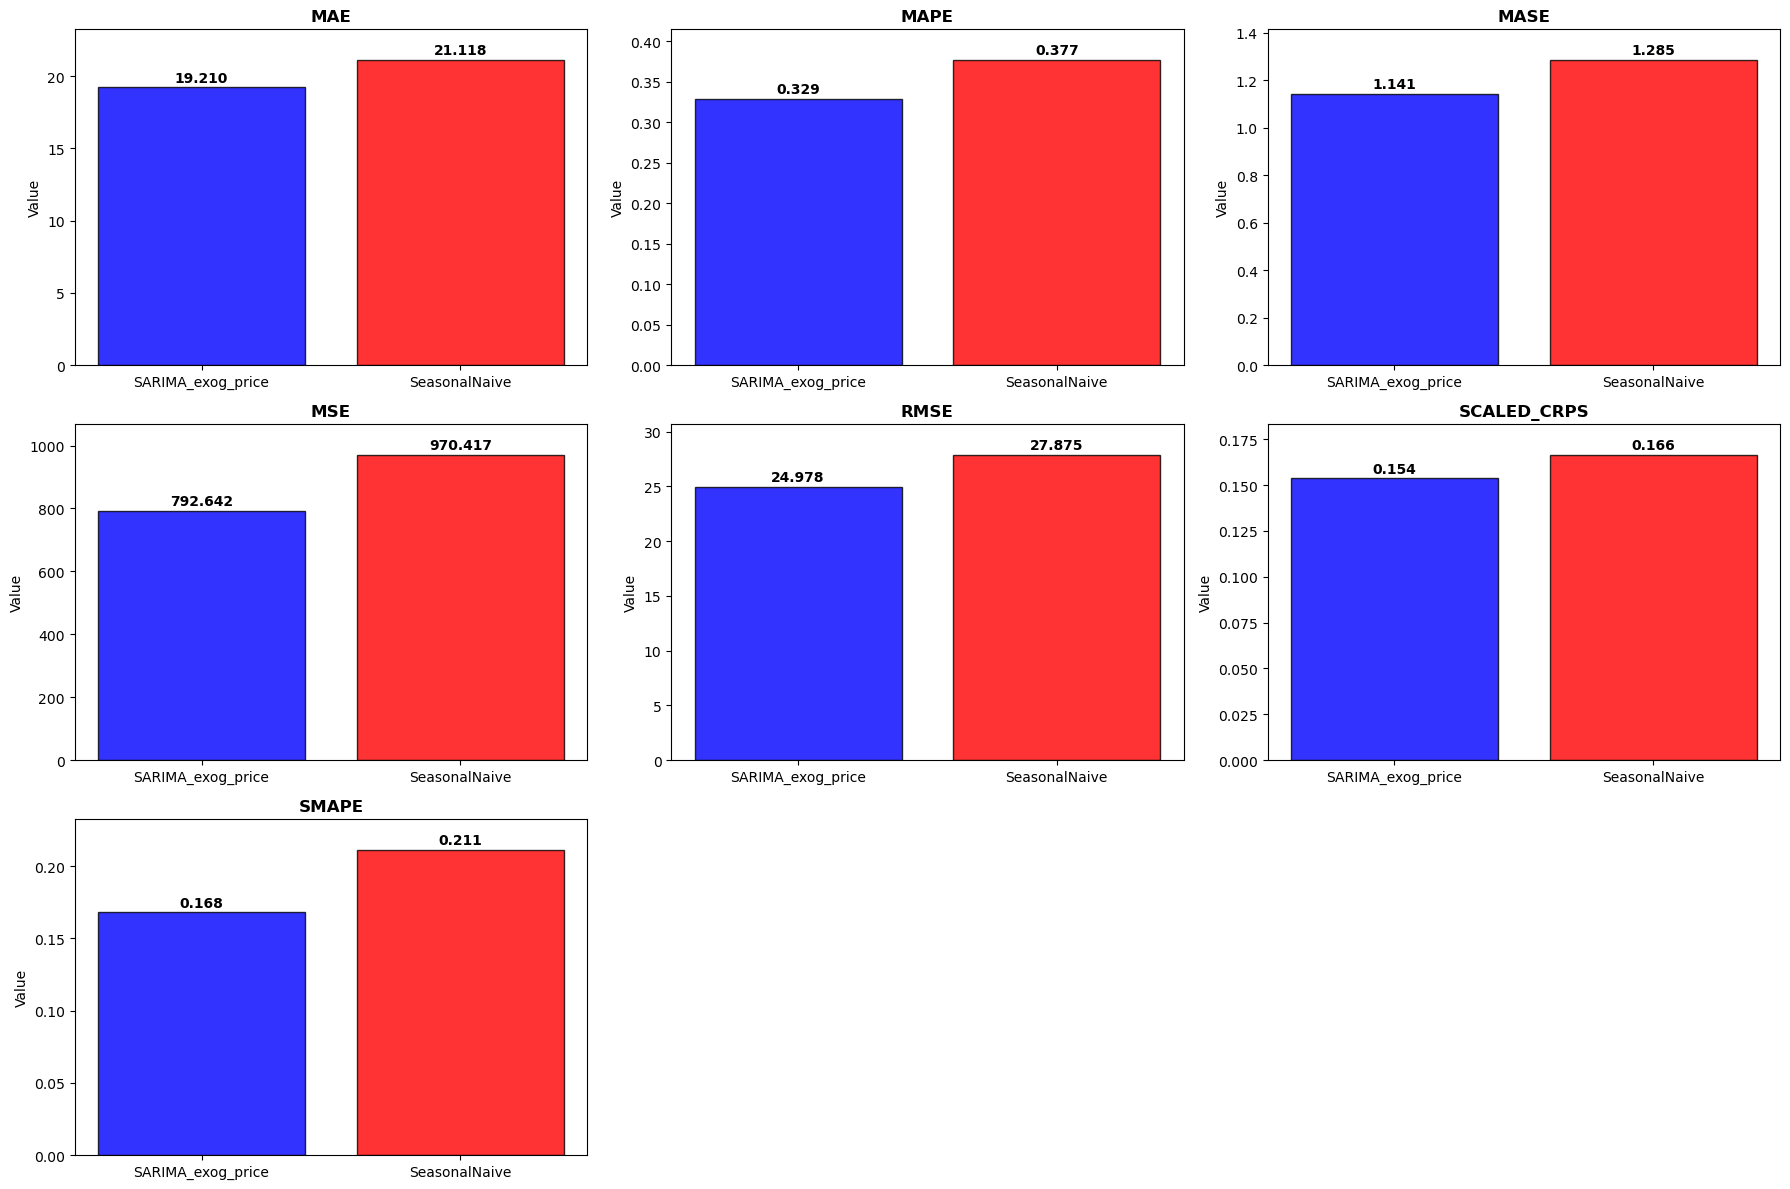

In [173]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

axes_flat = axes.flatten()

models = ['SARIMA_exog_price', 'SeasonalNaive']
x_pos = [0, 1]
colors = ['blue', 'red']

for i, row in final_eval.iterrows():
    ax = axes_flat[i]
    
    model_values = [row['SARIMA_exog_price'], row['SeasonalNaive']]
    
    bars = ax.bar(x_pos, model_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    for j, (bar, value) in enumerate(zip(bars, model_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_title(row['metric'].upper(), fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, ha='center')
    ax.set_ylabel('Value')
    max_value = max(model_values)
    ax.set_ylim(0, max_value * 1.1)

fig.delaxes(axes_flat[7])

axes_flat[8].set_visible(False)

plt.tight_layout()
plt.show()